# import lib

In [1]:
# from keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
# from tensorflow.keras.models import Sequential, Model,model_from_json
import torch
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import log10, sqrt
# from tensorflow.python.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import tf2onnx
import onnx
# from tf.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from onnx_tf.backend import prepare
from sklearn.model_selection import train_test_split

c:\Users\USER\anaconda3\envs\anime2d\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [18]:
## check onnx version
from onnx import __version__, IR_VERSION
from onnx.defs import onnx_opset_version
print(f"onnx.__version__={__version__!r}, opset={onnx_opset_version()}, IR_VERSION={IR_VERSION}")

onnx.__version__='1.14.1', opset=19, IR_VERSION=9


# pre processing

## load image

In [3]:
path = glob.glob('waifu_gan/Waifu-GAN/*.jpeg')

In [4]:
img_ori = []
for idx, img_path in enumerate(path):
    img = Image.open(img_path)
    img = img.resize((256,256))
    img_ori.append(img)

In [6]:
len(img_ori) # must be 92

92

## Image Augmentation

In [5]:
rotation_range = 15
width_shift_range = 0.125
height_shift_range = 0.125
shear_range = 0.1
zoom_range = 0.125
horizontal_flip = True

noise_mean = 60
noise_std = 60
noise_factor = 0.75

In [6]:
## noise
def add_gaussian_noise(img):

    img_noisy = img+(noise_factor * (np.random.normal(loc=noise_mean,scale=noise_std,size=img.shape)))
    img_noisy = np.clip(img_noisy, 0, 255)
    return img_noisy

In [14]:
datagen = image.ImageDataGenerator( rotation_range=rotation_range,
width_shift_range=width_shift_range,
height_shift_range=height_shift_range,
shear_range=shear_range,
zoom_range=zoom_range,
horizontal_flip=horizontal_flip,
fill_mode = 'constant',
preprocessing_function = add_gaussian_noise)

## train test split

In [2]:
random_state=99
test_size = 0.3

In [4]:
img_ori = glob.glob('waifu_gan/Waifu-GAN/*.jpeg')

In [5]:
train,test = train_test_split(img_ori,test_size=test_size,random_state=random_state)
train,val = train_test_split(train,test_size=test_size,random_state=random_state)

In [17]:
# Prepare train data
count = 0
for img in train:
    width, height = img.size
    resized_img = img.resize((320, 320), resample=Image.LANCZOS)
    small_img = resized_img.resize((160, 160), resample=Image.LANCZOS)
    resized_img = np.array(resized_img, ndmin=4)
    small_img = np.array(small_img, ndmin=4)
    for _ in range(10):
        flow = datagen.flow(small_img, resized_img, batch_size=1)
        gen_img = flow.next()
        cv2.imwrite('datasets/hq_train/tr' + str(count) + '.png', cv2.cvtColor(gen_img[1][0], cv2.COLOR_RGB2BGR))
        cv2.imwrite('datasets/lq_train/tr' + str(count) + '.png', cv2.cvtColor(gen_img[0][0], cv2.COLOR_RGB2BGR))
        count += 1

In [15]:
# Prepare validation data
count = 0
for img in val:
    width, height = img.size
    resized_img = img.resize((320, 320), resample=Image.LANCZOS)
    small_img = resized_img.resize((160, 160), resample=Image.LANCZOS)
    resized_img = np.array(resized_img, ndmin=4)
    small_img = np.array(small_img, ndmin=4)
    for _ in range(10):
        flow = datagen.flow(small_img, resized_img, batch_size=1)
        gen_img = flow.next()
        cv2.imwrite('datasets/hq_val/val' + str(count) + '.png', cv2.cvtColor(gen_img[1][0], cv2.COLOR_RGB2BGR))
        cv2.imwrite('datasets/lq_val/val' + str(count) + '.png', cv2.cvtColor(gen_img[0][0], cv2.COLOR_RGB2BGR))
        count += 1

In [16]:
# Prepare test data
count = 0
for img in test:
    width, height = img.size
    resized_img = img.resize((320, 320), resample=Image.LANCZOS)
    small_img = resized_img.resize((160, 160), resample=Image.LANCZOS)
    resized_img = np.array(resized_img, ndmin=4)
    small_img = np.array(small_img, ndmin=4)
    for _ in range(10):
        flow = datagen.flow(small_img, resized_img, batch_size=1)
        gen_img = flow.next()
        cv2.imwrite('datasets/hq_test/te' + str(count) + '.png', cv2.cvtColor(gen_img[1][0], cv2.COLOR_RGB2BGR))
        cv2.imwrite('datasets/lq_test/te' + str(count) + '.png', cv2.cvtColor(gen_img[0][0], cv2.COLOR_RGB2BGR))
        count += 1

In [6]:
train_size = len(train)
test_size = len(test)
val_size = len(val)

print(train_size, test_size, val_size)

44 28 20


## import model

In [7]:
waifu_model_path = "waifu2x_onnx_models_20230504\\onnx_models\\cunet\\art\\scale2x.onnx"

In [8]:
import onnx2torch

In [9]:
model = onnx.load(waifu_model_path)

In [10]:
torch_model = onnx2torch.convert(model)

In [11]:
from torchvision import transforms
from datasets.dataset import LoadDataset

In [12]:
# Define tranforms function
transform = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
num_epoch = 10
batch_size = 20

In [14]:
# Create data loader for training
train_dataset = LoadDataset(low_quality_folder='datasets\lq_train', high_quality_folder='datasets\hq_train', transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create data loader for testing
test_dataset = LoadDataset(low_quality_folder='datasets\lq_test', high_quality_folder='datasets\hq_test', transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Create data loader for validation
val_dataset = LoadDataset(low_quality_folder='datasets\lq_val', high_quality_folder='datasets\hq_val', transform=transform)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [15]:
lr=0.001
betas=(0.9, 0.999)

In [17]:
optimizer = torch.optim.AdamW(torch_model.parameters(), lr=0.001 , betas=(0.9, 0.999))

In [18]:
from nunif.nunif.modules.auxiliary_loss import AuxiliaryLoss
from nunif.nunif.modules.lbp_loss import YLBP

In [19]:
#loss
criterion = AuxiliaryLoss([
            YLBP(),
            YLBP(),
        ], weight=(1.0, 0.5))

In [ ]:
for name, param in torch_model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}")
        print(f"Shape: {param.shape}")
        print(f"Value: {param.data}")
        print("\n")

In [ ]:
# Train and validate generator
for epoch in range(num_epoch):
    # Training
    # Set to train mode
    torch_model.train()
    train_loss = 0
    for i, (lq_images, hq_images) in enumerate(train_data_loader):
        optimizer.zero_grad()  # Zero the gradients
        lq_outputs = torch_model(lq_images)  # Forward pass
        loss = criterion(lq_outputs, hq_images)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item() * lq_images.size(0)
    average_train_loss = train_loss / len(train_data_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epoch}, Average Training Loss: {average_train_loss:.4f}')

    # Validation
    torch_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for lq_images, hq_images in val_data_loader:  # Assuming val_data_loader is your validation DataLoader instance
            val_outputs = torch_model(lq_images)  # Forward pass for validation data
            val_loss += criterion(val_outputs, hq_images).item() * lq_images.size(0)
        
    average_val_loss = val_loss / len(val_data_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epoch}, Average Validation Loss: {average_val_loss:.4f}')

# ไม่ใช้

In [26]:
onnx_model = onnx.load("waifu2x_onnx_models_20230504\\onnx_models\\cunet\\art\\scale2x.onnx")
onnx.checker.check_model(onnx_model)

In [28]:
onnx_tf_model = prepare(onnx_model)

In [ ]:
onnx_tf_model.export_graph("waifu2x_onnx_models_20230504\\onnx_models\\cunet\\art\\scale2x.pb")

In [30]:
x = x if isinstance(x, list) else [x]
feed = dict([(input.name, x[n]) for n, input in enumerate(m.get_inputs())])

TypeError: export_graph() got an unexpected keyword argument 'opset'

In [ ]:
tf_rep.run

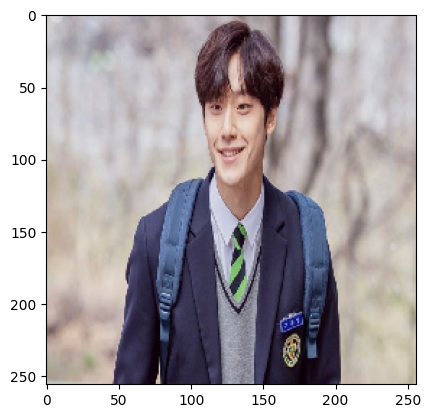

In [175]:
plt.imshow(x)

In [176]:
x.shape

(256, 256, 3)

In [177]:
x = np.expand_dims(x, axis=0)

In [178]:
x.shape

(1, 256, 256, 3)

In [179]:
x = x.transpose(0,3,1,2)

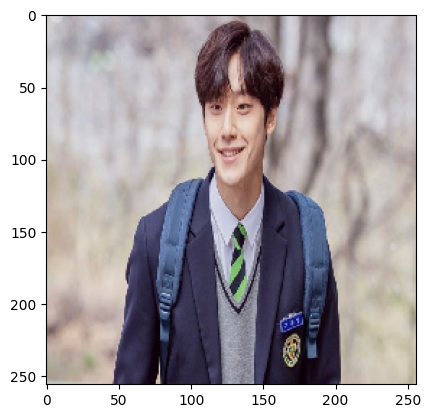

In [180]:
plt.imshow(x[0].transpose(1,2,0))

In [181]:
x.shape

(1, 3, 256, 256)

In [182]:
x = x if isinstance(x, list) else [x]
feed = dict([(input.name, x[n]) for n, input in enumerate(m.get_inputs())])

In [183]:
img = Image.open("dataset\\dohyun\\dohyun.jpg").resize((512,512))
pred_onnx = m.run(None,feed)[0]

In [184]:
pred_onnx.shape

(1, 3, 440, 440)

In [185]:
pred = np.squeeze(pred_onnx)

In [186]:
pred.shape

(3, 440, 440)

In [187]:
pred.argsort().shape

(3, 440, 440)

In [188]:
pred = pred.transpose(1,2,0)

In [189]:
pred.shape

(440, 440, 3)

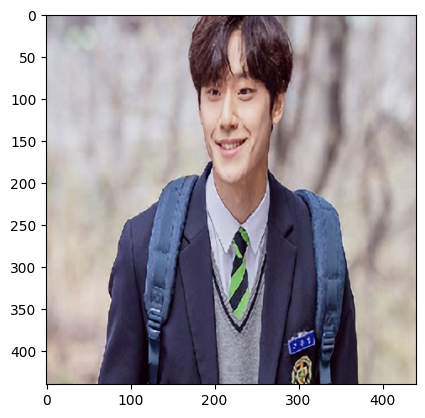

In [190]:
plt.imshow(pred)

In [4]:
onnx_model = onnx.load("waifu2x_onnx_models_20230504\\onnx_models\\cunet\\art\\noise3_scale2x.onnx")
onnx.checker.check_model(onnx_model)

In [5]:
tf_rep = prepare(onnx_model)

In [6]:
import onnxruntime as rt

In [119]:
onnx_model.graph.input[0]

NameError: name 'onnx_model' is not defined

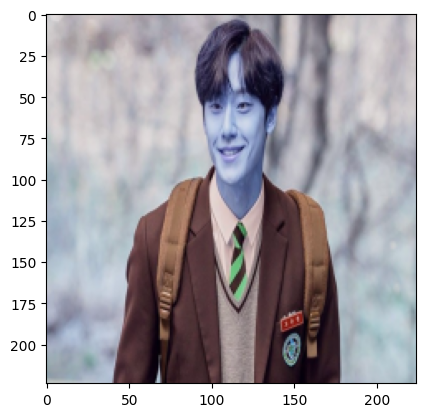

In [18]:
img = cv2.imread('dataset\dohyun\dohyun.jpg')
img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
plt.imshow(img)

In [20]:
img.shape

(224, 224, 3)

In [15]:
np.asarray([img], dtype=np.float32).shape

(1, 224, 224, 3)

In [16]:
img = np.asarray([img], dtype=np.float32).transpose(0,3,1,2)

In [17]:
img.shape

(1, 3, 224, 224)

In [ ]:
tf_rep.run([img])
